This notebook applies hierarchical bayesian modeling using two variables: precipitation and distance to water bodies

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from tqdm import tqdm
import theano.tensor as tt
import scipy.stats as stats 

import geopandas as gpd
from utils import *
tqdm.pandas()

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Pre-Processing

In [2]:
# read data
df = pd.read_csv("../data/hierarchical_septics_v2.csv")
df

,GAZ_ID,HU_12_NAME,AreaHUC12,tblSGA_Property.address_full_property,tblSGA_Property.gis_long_property,tblSGA_Property.gis_lat_property,tblSGA_Property.county_property,waterSupply,typeOfStructure,waterUsageBy,...,ppt_2004,ppt_2005,ppt_2006,ppt_2007,ppt_2008,ppt_2009,ppt_2010,ppt_2011,ppt_2012,ppt_2013
0,-1043,West Chickamauga Creek,117.245835,", Chickamauga, GA 30707",-85.290247,34.871150,WALKER,NaN,Mobile Home Park,NaN,...,6.538458,7.547637,8.493404,7.048221,6.098760,9.456309,9.662457,8.704074,10.474772,10.176624
1,-1043,West Chickamauga Creek,117.245835,"1060 RED BELT RD , CHICKAMAUGA, GA 30707",-85.261777,34.880789,CATOOSA,NaN,Single-Family Residence,NaN,...,6.468787,7.275261,8.786106,7.902163,6.443125,10.950521,9.853490,9.154307,10.876559,11.860751
2,-1043,West Chickamauga Creek,117.245835,"112 HILLCREST DR , RINGGOLD, GA 30736",-85.189749,34.972391,CATOOSA,Public,Single-Family Residence,Bedroom Numbers,...,6.945490,6.974487,6.909498,7.093376,6.222970,9.299619,9.405978,7.935056,10.322979,10.158866
3,-1043,West Chickamauga Creek,117.245835,"132 BROWNHILL LN , RINGGOLD, GA 30736",-85.206500,34.921100,CATOOSA,NaN,Single-Family Residence,NaN,...,6.673983,7.174273,8.357747,7.540320,6.295525,10.296205,9.786796,8.836207,10.581431,11.162181
4,-1043,West Chickamauga Creek,117.245835,"86 BROWNWOOD LN , RINGGOLD, GA 30736",-85.206100,34.922400,CATOOSA,NaN,Single-Family Residence,NaN,...,6.673983,7.174273,8.357747,7.540320,6.295525,10.296205,9.786796,8.836207,10.581431,11.162181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4318,-414346,Raulerson Swamp-Satilla River,248.045110,"Wilson RD , ,",-82.002204,31.259601,CHATTAHOOCHEE,Public,Mobile Home Park,NaN,...,7.048662,6.554801,6.833982,6.981873,10.003736,10.381194,6.832457,7.662163,7.462587,7.132818
4319,-414256,Catfish Creek-St. Marys River,114.388085,Woodland Ct. GA,-81.671373,30.793011,CLAYTON,NaN,RESIDENCE,NaN,...,5.372358,9.307037,7.603650,7.313950,8.098331,7.670040,5.943173,7.328537,7.283129,8.779465
4320,-450406,Bear Creek,62.004161,Woodlawn Ave GA,-84.296549,33.384176,CLAYTON,NaN,RESIDENCE,NaN,...,7.505739,6.158663,4.234353,7.719730,7.363442,5.817266,5.784439,4.799772,5.759576,8.461532
4321,-450406,Bear Creek,62.004161,Woodlawn Ave. GA,-84.296549,33.384176,CLAYTON,NaN,RESIDENCE,NaN,...,7.505739,6.158663,4.234353,7.719730,7.363442,5.817266,5.784439,4.799772,5.759576,8.461532


In [3]:
# keep only relevant columns
df = df.dropna(subset=["sewageSystem", "ppt_2013", "water_dist"]).reset_index(drop=True)

In [4]:
# encode categorical sewage system
enc, actual = pd.factorize(df["sewageSystem"])
df["sewageSystem_enc"] = enc
print(actual)
df.loc[df.sewageSystem_enc == 0, "sewageSystem_enc"] = 0 # need repair
df.loc[(df.sewageSystem_enc == 1) | (df.sewageSystem_enc == 2), "sewageSystem_enc"] = 1 # new + addition

Index(['Repair', 'New', 'Addition'], dtype='object')


In [5]:
# get balanced class (septics needing repair are not as many)
num_repair = len(df[df['sewageSystem_enc'] == 0].values)
print(f'repairs: {num_repair/len(df)*100}%, non-repairs: {(len(df) - num_repair)/len(df)*100}%')

# split equally
df = pd.concat((df[df['sewageSystem_enc'] == 0], df[df['sewageSystem_enc'] == 1][:num_repair]))

repairs: 11.044377711044378%, non-repairs: 88.95562228895562%


In [6]:
# separate septics based on their locations within a basin
basin_idx, basins = pd.factorize(df["HU_12_NAME"])
coords = {"basin": basins, "septic": np.arange(len(df))}

# Hierarchical Bayesian Model

- Group septic systems based on their basin (~1560 basins)
- The effect of precipitation and distance to water bodies to septic's status

## Empirical Distributions

### a) Distance to water bodies

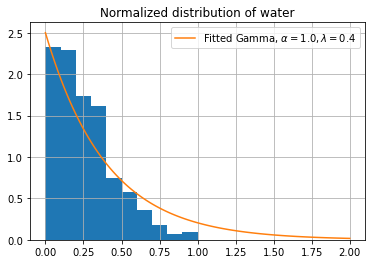

In [7]:
# get normalized value
df['water_dist_norm'] = (df.water_dist - df.water_dist.min()) / (df.water_dist.max() - df.water_dist.min())

# plotting distribution (using Gamma distribution with alpha=1 or exponential decay)
x = np.linspace(0,2,100)
y = stats.gamma.pdf(x, a=1.,scale=0.4)
df['water_dist_norm'].hist(density=True)
plt.plot(x,y, label="Fitted Gamma, $\\alpha=1.0, \lambda=0.4$")
plt.title("Normalized distribution of water")
plt.legend()

### b) Precipitation

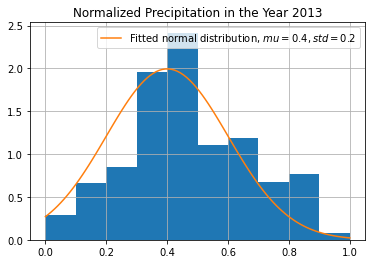

In [8]:
df['ppt_norm'] = (df.ppt_2013 - df.ppt_2013.min()) / (df.ppt_2013.max() - df.ppt_2013.min())

# plotting
x = np.linspace(0,1,100)
y = stats.norm.pdf(x, loc=0.4, scale=0.2)
df['ppt_norm'].hist(density=True)
plt.title("Normalized Precipitation in the Year 2013")
plt.plot(x,y, label="Fitted normal distribution, $mu=0.4, std=0.2$")
plt.legend()

## Case 1: Water Distance and Precipitation on Sewage Status $Y$

- LIVNEH monthly rainfall data from 1950-2013
- Fit annual maxima to a GenExtreme distribution to get return period graph
- Assign CDF value to each septic system [0...1]
- I'm only using the year 2013 values for analysis

The full hierarchical bayesian formula is as follows:
$$
Y_{k} \sim Bernoulli(\theta_{k})\\
\theta_{k} = \sigma(\beta_{0,k} + \beta_{w,k} * waterdist + \beta_{p,k} * precip)\\
\text{Water distance parameters}\\
\beta_{0,k} \sim N_{0,k}(\mu=\mu_{0}, \sigma=\theta_{0})\\
\mu_{0} \sim N_0(\mu=0, \sigma=10), \quad \theta_{0} \sim HN_0(\sigma=10)\\
\beta_{w,k} \sim \Gamma_{w,k}(\alpha=\alpha_w, \beta=\beta_w)\\
\alpha_w \sim HN_w(\sigma=1), \quad \beta_w \sim HN_w(\sigma=10)\\
\text{Precipitation parameters}\\
\beta_{p,k} \sim HN_{p,k}(\sigma=\sigma_p)\\
\sigma_p \sim HN_p(\sigma=10)\\
\text{the subscript $w$ and $p$ denote distance to water bodies and precipitation respectively, at the $k$-th basin}\\
\text{$\sigma$ (inverse logistic) function returns the binary value of 0 (repair) or 1 (new/addition)}
$$

In [9]:
# Modeling
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data("basin", basin_idx, dims="septic")
    water_d = pm.Data("water_d", df.water_dist_norm.values, dims="septic")
    ppt_d = pm.Data("ppt_d", df.ppt_norm.values, dims="septic")

    # global model parameters
    wtr_alpha = pm.HalfNormal("wtr_alpha", sigma=1.)
    wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.HalfNormal("ppt_mu", sigma=0.5)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    mu_c = pm.Normal("mu_c", mu=0, sigma=10)
    sigma_c = pm.HalfNormal("sigma_c", 10)

    # septic-specific model parameters
    wtr_dist = pm.Gamma("wtr_dist", alpha=wtr_alpha, beta=wtr_beta, dims="basin")
    ppt = pm.HalfNormal("ppt", sigma=ppt_sig, dims="basin")
    c = pm.Normal("c", mu=mu_c, sigma=sigma_c, dims="basin")
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin_idx] 
                                    + wtr_dist[basin_idx] * water_d 
                                    + ppt[basin_idx] * ppt_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli("failures", failure_theta, observed=df["sewageSystem_enc"])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=200, cores=4, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, ppt, wtr_dist, sigma_c, mu_c, ppt_sig, ppt_mu, wtr_beta, wtr_alpha]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 37 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'wtr_dist'}>,
        <AxesSubplot:title={'center':'wtr_dist'}>],
       [<AxesSubplot:title={'center':'ppt'}>,
        <AxesSubplot:title={'center':'ppt'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>]], dtype=object)

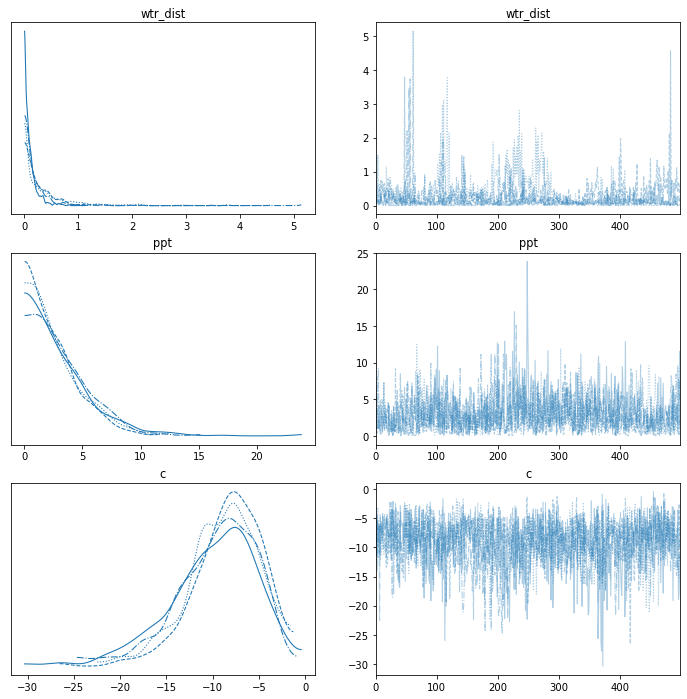

In [10]:
# get sample basin for analysis
sample_coords = {'basin': df.HU_12_NAME[:2].values}

# analyze the posterior distribution (fitted parameters)
az.plot_trace(trace, var_names=["wtr_dist", "ppt", "c"], coords=sample_coords, figsize=(12,12), compact=True)

In [ ]:
# evaluate model
y = df.sewageSystem_enc.to_list()
acc = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

## Case 2: With Past Precipitation

The full hierarchical bayesian formula is as follows:
$$
Y_{k} \sim Bernoulli(\theta_{k})\\
\theta_{k} = \sigma(\beta_{0,k} + \beta_{w,k} * waterdist + \beta_{p,k} * precip + \beta_{p,k} * precippast)\\
\text{Water distance parameters}\\
\beta_{0,k} \sim N_{0,k}(\mu=\mu_{0}, \sigma=\theta_{0})\\
\mu_{0} \sim N_0(\mu=0, \sigma=10), \quad \theta_{0} \sim HN_0(\sigma=10)\\
\beta_{w,k} \sim \Gamma_{w,k}(\alpha=\alpha_w, \beta=\beta_w)\\
\alpha_w \sim HN_w(\sigma=1), \quad \beta_w \sim HN_w(\sigma=10)\\
\text{Precipitation parameters}\\
\beta_{p,k} \sim HN_{p,k}(\sigma=\sigma_p)\\
\sigma_p \sim HN_p(\sigma=10)\\
\text{the subscript $w$ and $p$ denote distance to water bodies and precipitation respectively, at the $k$-th basin}\\
\text{$\sigma$ (inverse logistic) function returns the binary value of 0 (new/addition) or 1 (repair)}
$$

In [13]:
# generate the ppt_past variable (eg. 2012)
var = 'ppt_2012'
df['ppt_past_norm'] = (df[var] - df[var].min()) / (df[var].max() - df[var].min())

In [15]:
# Modeling
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data("basin", basin_idx, dims="septic")
    water_d = pm.Data("water_d", df.water_dist_norm.values, dims="septic")
    ppt_d = pm.Data("ppt_d", df.ppt_norm.values, dims="septic")
    ppt_past_d = pm.Data("ppt_past_d", df.ppt_past_norm.values, dims="septic")

    # global model parameters (the formulation for ppt_past is identical to ppt)
    wtr_alpha = pm.HalfNormal("wtr_alpha", sigma=1.)
    wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.HalfNormal("ppt_mu", sigma=0.5)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    ppt_past_mu = pm.HalfNormal("ppt_past_mu", sigma=0.5)
    ppt_past_sig = pm.HalfNormal("ppt_past_sig", sigma=10)
    mu_c = pm.Normal("mu_c", mu=0, sigma=10)
    sigma_c = pm.HalfNormal("sigma_c", 10)

    # septic-specific model parameters
    wtr_dist = pm.Gamma("wtr_dist", alpha=wtr_alpha, beta=wtr_beta, dims="basin")
    ppt = pm.HalfNormal("ppt", sigma=ppt_sig, dims="basin")
    ppt_past = pm.HalfNormal("ppt_past", sigma=ppt_past_sig, dims="basin")
    c = pm.Normal("c", mu=mu_c, sigma=sigma_c, dims="basin")
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin_idx] 
                                    + wtr_dist[basin_idx] * water_d 
                                    + ppt[basin_idx] * ppt_d
                                    + ppt_past[basin_idx] * ppt_past_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli("failures", failure_theta, observed=df["sewageSystem_enc"])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=200, cores=4, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, ppt_past, ppt, wtr_dist, sigma_c, mu_c, ppt_past_sig, ppt_past_mu, ppt_sig, ppt_mu, wtr_beta, wtr_alpha]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'wtr_dist'}>,
        <AxesSubplot:title={'center':'wtr_dist'}>],
       [<AxesSubplot:title={'center':'ppt'}>,
        <AxesSubplot:title={'center':'ppt'}>],
       [<AxesSubplot:title={'center':'ppt_past'}>,
        <AxesSubplot:title={'center':'ppt_past'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>]], dtype=object)

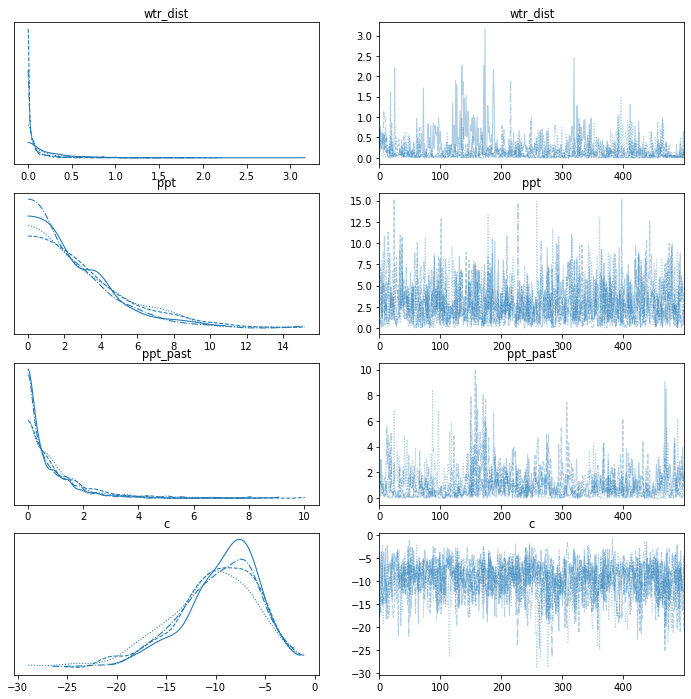

In [16]:
# get sample basin for analysis
sample_coords = {'basin': df.HU_12_NAME[:2].values}

# analyze the posterior distribution (fitted parameters)
az.plot_trace(trace, var_names=["wtr_dist", "ppt", "ppt_past", "c"], coords=sample_coords, figsize=(12,12), compact=True)

In [17]:
# evaluate model
y = df.sewageSystem_enc.to_list()
acc = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/home/user/anaconda3/envs/sentinel/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 89.72809667673715%
